In [1]:
%matplotlib inline
import spikeinterface.full as si
import numpy as np
from os.path import join, split
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
spikeglx_folder = Path(r'/home/user/Data/guido/Subjects/466396/20241031/raw_ephys_data/probe01/')

if len(glob(join(spikeglx_folder, '*.cbin'))) > 0:
    rec = si.read_cbin_ibl(spikeglx_folder)
else:
    rec = si.read_spikeglx(spikeglx_folder, stream_id=f'imec{split(spikeglx_folder)[-1][-1]}.ap')
rec

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 119,659,725 samples 
                            3,988.66s (1.11 hours) - int16 dtype - 85.59 GiB

In [3]:
# Apply high-pass filter
print('\nApplying high-pass filter.. ')
rec_filtered = si.highpass_filter(rec, ftype='bessel', dtype='float32')

# Correct for inter-sample phase shift
print('Correcting for phase shift.. ')
rec_shifted = si.phase_shift(rec_filtered)

# Do common average referencing
print('Performing common average referencing.. ')
#rec_comref = si.common_reference(rec_filtered, reference='local')
rec_comref = si.common_reference(rec_filtered)


Applying high-pass filter.. 
Correcting for phase shift.. 
Performing common average referencing.. 


In [4]:
print('Detecting and interpolating over bad channels.. ')

# Detect dead channels
bad_channel_ids, all_channels = si.detect_bad_channels(rec_filtered, seed=42)
prec_dead_ch = np.sum(all_channels == 'dead') / all_channels.shape[0]
print(f'{np.sum(all_channels == "dead")} ({prec_dead_ch*100:.0f}%) dead channels')
dead_channel_ids = rec_filtered.get_channel_ids()[all_channels == 'dead']

# Detect noisy channels
bad_channel_ids, all_channels = si.detect_bad_channels(rec_comref, method='mad', seed=42)
prec_noise_ch = np.sum(all_channels == 'noise') / all_channels.shape[0]
print(f'{np.sum(all_channels == "noise")} ({prec_noise_ch*100:.0f}%) noise channels')
noisy_channel_ids = rec_comref.get_channel_ids()[all_channels == 'noise']

# Interpolate over dead and noisy channels
rec_interpolated = si.interpolate_bad_channels(rec_shifted, np.concatenate((dead_channel_ids, noisy_channel_ids)))

Detecting and interpolating over bad channels.. 
0 (0%) dead channels
0 (0%) noise channels


In [5]:
print('Destriping.. ')
if np.unique(rec_interpolated.get_property('group')).shape[0] > 1:
    print('Multi-shank probe detected, doing destriping per shank')
    rec_split = rec_interpolated.split_by(property='group')
    rec_destripe = []
    for sh in range(len(rec_split)):
        rec_destripe.append(si.highpass_spatial_filter(rec_split[sh]))
    rec_destriped = si.aggregate_channels(rec_destripe, renamed_channel_ids=rec_interpolated.get_channel_ids())
else:
    rec_destriped = si.highpass_spatial_filter(rec_interpolated)

Destriping.. 
Multi-shank probe detected, doing destriping per shank


In [6]:
%matplotlib widget
si.plot_traces({'raw':rec, 'filtered': rec_filtered, 'car': rec_comref, 'destriped': rec_destriped},
               time_range=[1000, 1000.04], color='k', backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

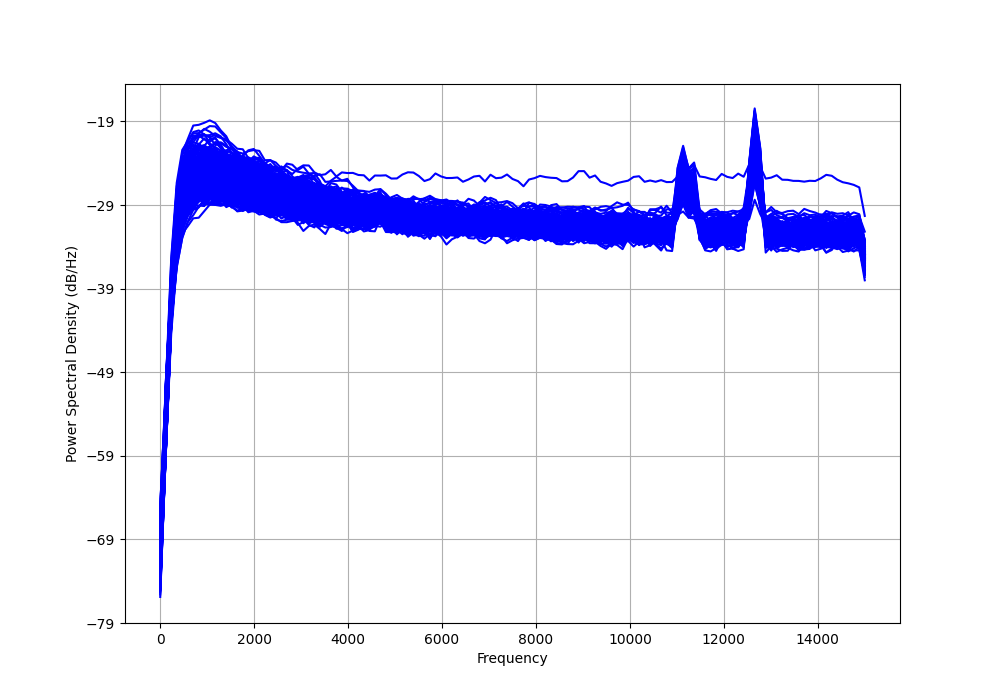

In [7]:
# Plot spectral density
data_chunk = si.get_random_data_chunks(
    rec_destriped,
    num_chunks_per_segment=1,
    chunk_size=30000,
    seed=0
)

fig, ax = plt.subplots(figsize=(10, 7))
for tr in data_chunk.T:
    p, f = ax.psd(tr, Fs=rec_destriped.sampling_frequency, color="b")

In [8]:
# Apply notch filter to peaks
#rec_destriped_notch = si.notch_filter(rec_destriped, freq=3720, q=20)
rec_destriped_notch = si.notch_filter(rec_destriped, freq=11150, q=10)
rec_destriped_notch = si.notch_filter(rec_destriped_notch, freq=12640, q=20)

#rec_comref_notch = si.notch_filter(rec_comref, freq=3720, q=20)
rec_comref_notch = si.notch_filter(rec_comref, freq=11150, q=10)
rec_comref_notch = si.notch_filter(rec_comref_notch, freq=12640, q=20)

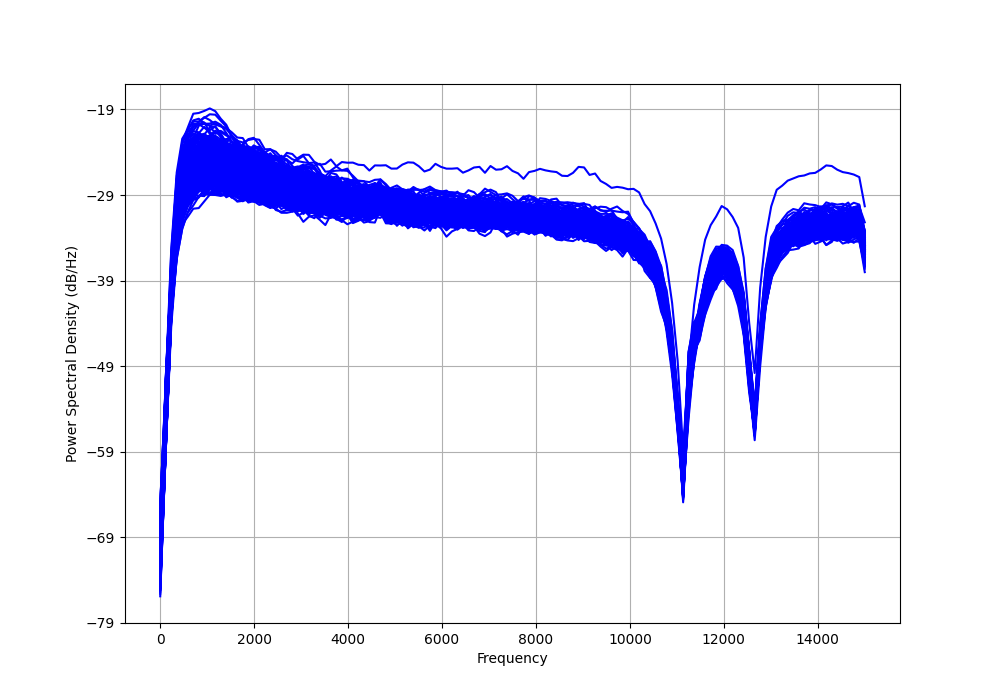

In [9]:
# Plot result of notch filter 
data_chunk = si.get_random_data_chunks(
    rec_destriped_notch,
    num_chunks_per_segment=1,
    chunk_size=30000,
    seed=0
)

fig, ax = plt.subplots(figsize=(10, 7))
for tr in data_chunk.T:
    p, f = ax.psd(tr, Fs=rec_destriped_notch.sampling_frequency, color="b")

In [10]:
%matplotlib widget
si.plot_traces({'destriped': rec_destriped, 'destriped notch': rec_destriped_notch,
                'car': rec_comref, 'car notch': rec_comref_notch},
               time_range=[1000, 1000.04], color='k', backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…